In [123]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

In [272]:
#单值定义
ss = StandardScaler()
tf.reset_default_graph()
# 波士顿房价数据
boston = load_boston()
boston_target_sc = ss.fit_transform(boston.target.reshape(-1, 1))
train_np = boston_target_sc[0:300]
test_np = boston_target_sc[301:505]

print('波士顿数据X:', x.shape)  # (506, 1)
# print(x[::100])
print('波士顿房价Y:', y.shape)
# print(y[::100])
# 数据标准化
# ss_x = preprocessing.StandardScaler()
# train_x_ss = ss_x.fit_transform(x.reshape(-1, 1))
# ss_y = preprocessing.StandardScaler()
# train_y_ss = ss_y.fit_transform(y.reshape(-1, 1))

BATCH_START = 0  # 建立 batch data 时候的 index
TIME_STEPS = 10  # backpropagation through time 的 time_steps
BATCH_SIZE = 20
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 1  # RNN 的 hidden unit size
LR = 0.006  # learning rate
# 保存session状态的位置
save_dir = './bst_save/ckpt/bst'

# logs_path = './bst_save/log/'


#200
def get_batch_boston():
    global train_x_list, train_y_list, BATCH_START, TIME_STEPS
    train_x_list, train_y_list = [], []
    for i in range(20):
        x1 = train_np[i:i + TIME_STEPS * BATCH_SIZE]
        y1 = train_np[i + 1:i + TIME_STEPS * BATCH_SIZE + 1]
#         print(x1.shape)
        #         y1=train_y[i:i+TIME_STEPS*BATCH_SIZE]
        x1 = x1.reshape(20, 10, -1)
        y1 = y1.reshape(20, 10, -1)
        train_x_list.append(x1.tolist())
        train_y_list.append(y1.tolist())
    train_x_np = np.array(train_x_list)
    train_y_np = np.array(train_y_list)

    seq = train_x_np
    res = train_y_np
    return [seq, res]

# 1
# def get_batch_boston():
#     train_x = train_np[:-1].reshape(-1, 1, 1)
#     print(train_x.shape)
# #     train_x = train_x.reshape(train_x_ss.shape[0], 1, train_x_ss.shape[1])
#     train_y = train_np[1:].reshape(-1, 1)
#     return [train_x,train_y]

def get_batch_boston_test():
    test_x = test_np[:-1].reshape(-1, 1, 1)
#     print(train_x.shape)
#     train_x = train_x.reshape(train_x_ss.shape[0], 1, train_x_ss.shape[1])
    test_y = test_np[1:].reshape(-1, 1)
    return [test_x,test_y]

波士顿数据X: (300,)
波士顿房价Y: (204,)


In [273]:
seq, res = get_batch_boston()
seq_test, res_test  = get_batch_boston_test()
# print(seq.shape)
# print(res.shape)

# print(seq[0:5])
# print(res[0:5])
# print(seq[0].reshape(-1,1,1),'|',seq[0].reshape(-1,1,1).shape)
# print(res[1],'|',res[1].reshape(-1,1).shape)
# print(train_x_ss[0:5])

In [283]:
class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size,
                 batch_size):
        '''
        :param n_steps: 每批数据总包含多少时间刻度
        :param input_size: 输入数据的维度
        :param output_size: 输出数据的维度 如果是类似价格曲线的话，应该为1
        :param cell_size: cell的大小
        :param batch_size: 每批次训练数据的数量
        '''
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(
                tf.float32, [None, 1, 1], name='xs')  #xs 有三个维度
#                 tf.float32, [None, n_steps, input_size], name='xs')  #xs 有三个维度
            self.ys = tf.placeholder(
                tf.float32, [None, 1], name='ys')  #ys 有三个维度
#                tf.float32, [None, n_steps, output_size], name='ys')  #ys 有三个维度
        with tf.variable_scope('in_hidden'):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell'):
            self.add_cell()
        with tf.variable_scope('out_hidden'):
            self.add_output_layer()
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)

    
    #增加一个输入层
    def add_input_layer(self, ):
        # l_in_x:(batch*n_step, in_size),相当于把这个批次的样本串到一个长度1000的时间线上，每批次50个样本，每个样本20个时刻
        l_in_x = tf.reshape(
            self.xs, [-1, self.input_size], name='2_2D')  #-1 表示任意行数
        # Ws (in_size, cell_size)
        Ws_in = self._weight_variable([self.input_size, self.cell_size])
        # bs (cell_size, )
        bs_in = self._bias_variable([
            self.cell_size,
        ])
        # l_in_y = (batch * n_steps, cell_size)
        with tf.name_scope('Wx_plus_b'):
            l_in_y = tf.matmul(l_in_x, Ws_in) + bs_in
        # reshape l_in_y ==> (batch, n_steps, cell_size)
        self.l_in_y = tf.reshape(
            l_in_y, [-1, self.n_steps, self.cell_size], name='2_3D')
    

    #多时刻的状态叠加层 CELL
    def add_cell(self):
#         print('BATCH_SIZE',self.batch_size)
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(
            self.cell_size, forget_bias=1.0, state_is_tuple=True)
        with tf.name_scope('initial_state'):
            self.cell_init_state = lstm_cell.zero_state(
                self.batch_size, dtype=tf.float32)
        #time_major=False 表示时间主线不是第一列batch
        self.cell_outputs, self.cell_final_state = tf.nn.dynamic_rnn(
            lstm_cell,
            self.l_in_y,
            initial_state=self.cell_init_state,
            time_major=False)

    # 增加一个输出层
    def add_output_layer(self):
        # shape = (batch * steps, cell_size)
        l_out_x = tf.reshape(
            self.cell_outputs, [-1, self.cell_size], name='2_2D')
        Ws_out = self._weight_variable([self.cell_size, self.output_size])
        bs_out = self._bias_variable([
            self.output_size,
        ])
        # shape = (batch * steps, output_size)
        with tf.name_scope('Wx_plus_b'):
            self.pred = tf.matmul(l_out_x, Ws_out) + bs_out  #预测结果
    
        
    # 计算损失
    def compute_cost(self):
        losses = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
            [tf.reshape(self.pred, [-1], name='reshape_pred')],
            [tf.reshape(self.ys, [-1], name='reshape_target')],
            [tf.ones([self.batch_size * self.n_steps], dtype=tf.float32)],
            average_across_timesteps=True,
            softmax_loss_function=self.ms_error,
            name='losses')
        with tf.name_scope('average_cost'):
            self.cost = tf.div(
                tf.reduce_sum(losses, name='losses_sum'),
                self.batch_size,
                name='average_cost')
            tf.summary.scalar('cost', self.cost)

    def ms_error(self, labels, logits):
        return tf.square(tf.subtract(labels, logits))
    
    

    def _weight_variable(self, shape, name='weights'):
        initializer = tf.random_normal_initializer(
            mean=0.,
            stddev=1.,
        )
        return tf.get_variable(shape=shape, initializer=initializer, name=name)

    def _bias_variable(self, shape, name='biases'):
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(name=name, shape=shape, initializer=initializer)

<IPython.core.display.Javascript object>


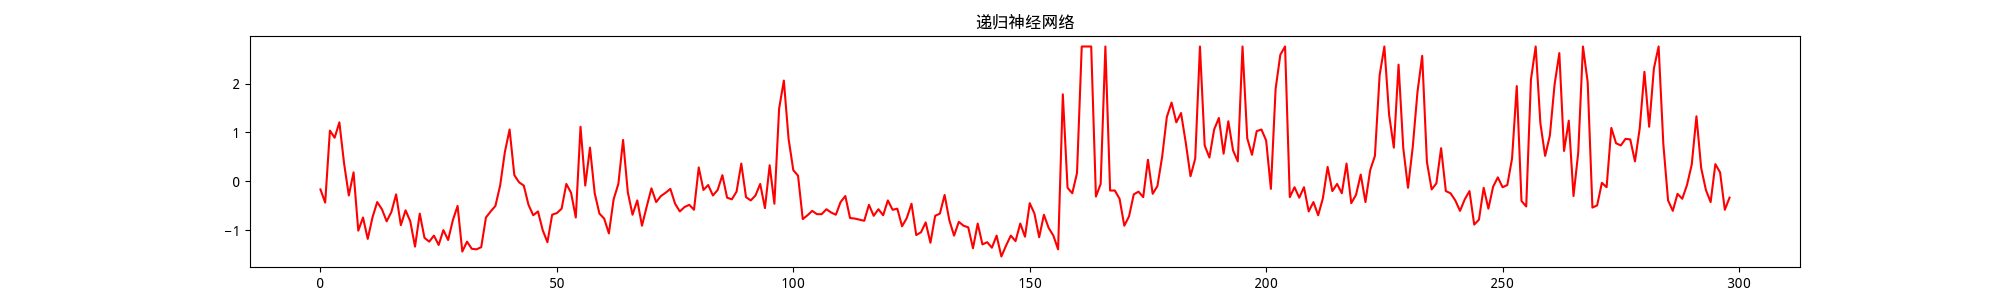

seq (20, 20, 10, 1)
res (20, 20, 10, 1)
0 cost:  8.8959
10 cost:  4.1513
20 cost:  3.9693
Model Trained and Saved


In [284]:
# 训练
%matplotlib notebook
# %matplotlib  inline
tf.reset_default_graph()
if __name__ == '__main__':
    # 设置画布初始属性和内容
    
    fig = plt.figure(figsize=(20, 3))  # dpi参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80
    axes = fig.add_subplot(1, 1, 1)
#     axes2 = fig.add_subplot(2, 1, 1)
    line3, = axes.plot(train_x_ss[0:-1], 'r', label='实际')
    plt.ion()
    plt.show()
    
    seq, res = get_batch_boston()
#     costlist = []
    print('seq',seq.shape)
    print('res',res.shape)
    model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    
    config = tf.ConfigProto(device_count={"CPU": 4}, # limit to num_cpu_core CPU usage
                inter_op_parallelism_threads = 2, 
                intra_op_parallelism_threads = 4,
                log_device_placement=True)
#     with tf.Session(config = config) as sess:
    # To Do

    
    sess = tf.Session(config = config)
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("logs", sess.graph)
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    sess.run(tf.global_variables_initializer())
    # relocate to the local dir and run this line to view it on Chrome (http://0.0.0.0:6006/):
    # $ tensorboard --logdir='logs'
    for j in range(30):  #训练200次
#         pred_res = []
        # 300
        seq, res = get_batch_boston()
#         print('seq',seq.shape)
#        用于300
        for i in range(seq.shape[0]-1):
            if i == 0:
#                 print('if')
                feed_dict = {
                    model.xs: seq[i].reshape(-1,1,1),
                    model.ys: res[i].reshape(-1,1),
                    # create initial state
                }
            else:
#                 print('else')
                feed_dict = {
                    model.xs: seq[i].reshape(-1,1,1),
                    model.ys: res[i].reshape(-1,1),
                    model.cell_init_state:
                    state  # use last state as the initial state for this run
                }

            
            _, cost, state, pred = sess.run([
                model.train_op, model.cost, model.cell_final_state, model.pred
            ],feed_dict=feed_dict)
#             pred_res.append(pred)
            result = sess.run(merged, feed_dict)
            writer.add_summary(result, i)
        if(j % 10 ==0):
            print('{0} cost: '.format(j), round(cost, 4))
#         pred_res = np.array(pred_res).reshape(1,1,-1)[0][0]
        BATCH_START = 0  #从头再来一遍
        try:
#             pass
            axes.lines.remove(line1)
#             axes2.lines.remove(line_c)
        except Exception:
            pass
        
        costlist.append(cost)
#         line_c, = axes2.plot(costlist,'y',label='cost')
        handles, labels = plt.gca().get_legend_handles_labels()
#         返回是, 是一个Line2D的对象，无逗号是一个包含了Line2D的数组
#         line1, = axes.plot(
#             range(100), pred.flatten()[-100:], 'b--', label='rnn计算结果 '+str(j))
#         line1, = axes.plot(pred_res, 'b--', label='rnn计算结果 '+str(j))
#         axes.grid()
#         fig.tight_layout()
#         plt.legend(handles=[line1,line3])
        plt.title('递归神经网络')
        fig.canvas.draw()
        time.sleep(0.1)
    plt.ioff()
    plt.show()
    
    # 保存模型
    saver = tf.train.Saver()
    saver.save(sess, save_dir,)
    print('Model Trained and Saved')

<IPython.core.display.Javascript object>


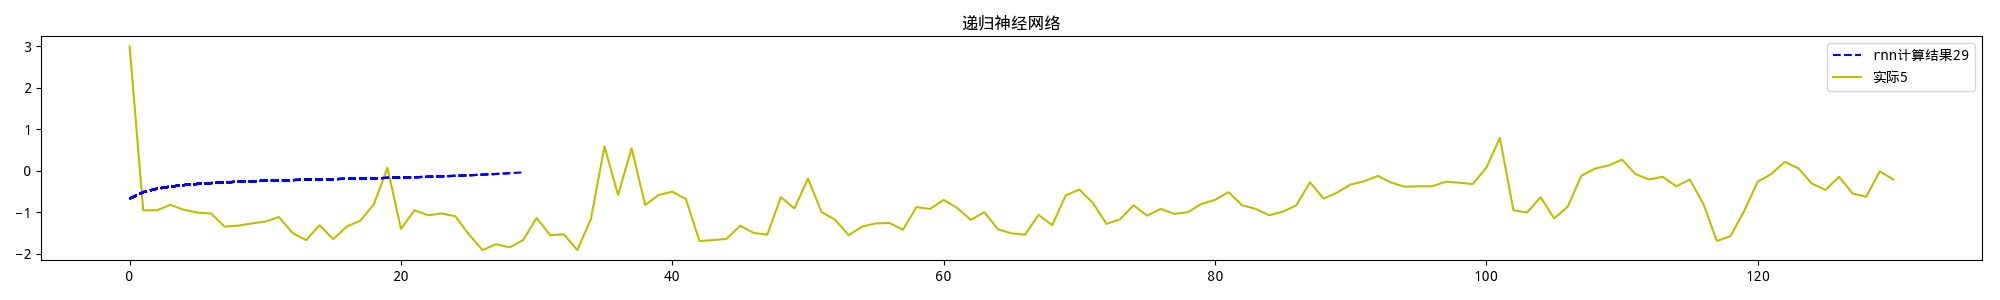

seq (20, 20, 10, 1)
INFO:tensorflow:Restoring parameters from ./bst_save/ckpt/bst
prev_seq (10, 1, 1)


In [286]:
# 预测 300 可用
%matplotlib qt
prime_word = '1'
plt_start = 71
loaded_graph = tf.Graph()
tf.reset_default_graph()
seq, res = get_batch_boston()
# BATCH_SIZE  = 1 
#改变 cell 的尺寸 和 输入数据的尺寸一致
model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, 1)
saver = tf.train.Saver()
fig = plt.figure(figsize=(20, 3))  # dpi参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80
axes = fig.add_subplot(1, 1, 1)
# train_y1 = train_y[190:490]
# train_y2 = train_y[0:300]
# train_y3 = train_y[0:506]
line5, = axes.plot(seq_test[plt_start:-1].flatten(), 'y', label='实际5')
plt.ion()
plt.show()
print('seq', seq.shape)
with tf.Session() as sess:
    # 加载保存过的session
    #     loader = tf.train.import_meta_graph(save_dir + '.meta')
    saver.restore(sess, './bst_save/ckpt/bst')
    #取训练集的最后一行，作为开始
#     prev_seq=train_x[-1]
#     prev_seq = seq[-1]
#     prev_seq = np.array(seq[plt_start]).reshape(-1,1,1)
    prev_seq = np.array(seq_test[plt_start:plt_start+10]).reshape(-1,1,1)
#      可用
#     prev_seq = np.array([train_x_np[50].tolist()])
    print('prev_seq', prev_seq.shape)
    predict=[]
    for i in range(30):
#         print('prev_seq_in',prev_seq)
        if i == 0:
#             print('if')
            feed_dict = {
                # create initial state
                model.xs: prev_seq
            }
        else:
#             print('else')
            feed_dict = {
                model.xs: prev_seq,
                # use last state as the initial state for this run
                model.cell_init_state: state 
            }
        state, next_seq = sess.run([model.cell_final_state, model.pred],
                               feed_dict=feed_dict)
#         print('next_seq',next_seq.shape)
#         print('next_seq',next_seq[-1])
#         print(type(predict))
#       下次的训练数据都是老一代的1-X加预测值的最后一位，所以数据可视化的时候，只需要展出最后更新那一位就可以了
#       梯度消失
#         print(next_seq.shape)
        predict.append(next_seq[-1])
#         predict = np.append(predict,next_seq)
#         print('prev_seq',prev_seq.reshape([-1]).shape
#         print('prev_seq',prev_seq.shape)
#         print('next_seq',next_seq.shape)
#         print('next_seq',next_seq[-1].shape)
#         print('prev_seq_out',prev_seq)
#        丢弃首位，插入末位，输入的数据保持0-8位的一致性，形成连续
#         prev_seq = np.append(prev_seq.reshape(TIME_STEPS)[1:],next_seq.reshape(TIME_STEPS)[-1]).reshape(1,10,1)
#         prev_seq = prev_seq.reshape(1,10,1)

#         print('prev_seq[1:]',prev_seq[1:])
#        全新输入，梯度爆炸
        prev_seq = next_seq.reshape(-1,1,1)
#         prev_seq = np.vstack((prev_seq[1:],[next_seq]))

        line1, = axes.plot(predict, 'b--', label='rnn计算结果' + str(i))
        axes.grid()
        fig.tight_layout()
        plt.legend(handles=[line1, line5])
        plt.title('递归神经网络')
        fig.canvas.draw()
        time.sleep(0.1)

    BATCH_START = 0
    plt.ioff()
    plt.show()

Traceback (most recent call last):
  File "/home/python/anaconda3/envs/specialtopic/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/python/anaconda3/envs/specialtopic/lib/python3.6/site-packages/matplotlib/backends/backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/home/python/anaconda3/envs/specialtopic/lib/python3.6/site-packages/matplotlib/_pylab_helpers.py", line 54, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


<IPython.core.display.Javascript object>


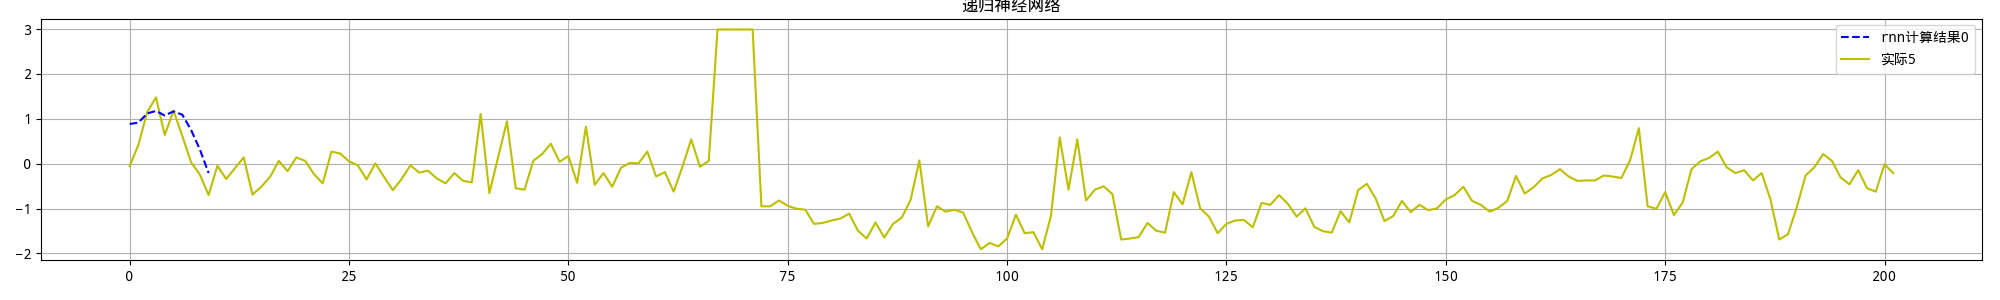

seq (20, 20, 10, 1)
INFO:tensorflow:Restoring parameters from ./bst_save/ckpt/bst
prev_seq (10, 1, 1)
i 0
next_seq (10, 1)


In [298]:
# 预测 200 全量
%matplotlib qt
prime_word = '1'
plt_start = 0
loaded_graph = tf.Graph()
tf.reset_default_graph()
seq, res = get_batch_boston()
# BATCH_SIZE  = 1 
#改变 cell 的尺寸 和 输入数据的尺寸一致
model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, 1)
saver = tf.train.Saver()
fig = plt.figure(figsize=(20, 3))  # dpi参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80
axes = fig.add_subplot(1, 1, 1)
# train_y1 = train_y[190:490]
# train_y2 = train_y[0:300]
# train_y3 = train_y[0:506]
line5, = axes.plot(seq_test[plt_start:-1].flatten(), 'y', label='实际5')
plt.ion()
plt.show()
print('seq', seq.shape)
with tf.Session() as sess:
    # 加载保存过的session
    #     loader = tf.train.import_meta_graph(save_dir + '.meta')
    saver.restore(sess, './bst_save/ckpt/bst')
    #取训练集的最后一行，作为开始
#     prev_seq=train_x[-1]
#     prev_seq = seq[-1]
#     prev_seq = np.array(seq[plt_start]).reshape(-1,1,1)
    prev_seq = np.array(seq_test[plt_start:plt_start+10]).reshape(-1,1,1)
#      可用
#     prev_seq = np.array([train_x_np[50].tolist()])
    print('prev_seq', prev_seq.shape)
    predict=[]
    for i in range(1):
        print('i',i)
#         print('prev_seq_in',prev_seq)
        if i == 0:
#             print('if')
            feed_dict = {
                # create initial state
                model.xs: prev_seq.reshape(-1,1,1)
            }
        else:
#             print('else')
            feed_dict = {
                model.xs: prev_seq,
                # use last state as the initial state for this run
                model.cell_init_state: state 
            }
        state, next_seq = sess.run([model.cell_final_state, model.pred],
                               feed_dict=feed_dict)
#         print('next_seq',next_seq.shape)
#         print('next_seq',next_seq[-1])
#         print(type(predict))
#       下次的训练数据都是老一代的1-X加预测值的最后一位，所以数据可视化的时候，只需要展出最后更新那一位就可以了
#       梯度消失
#         print(next_seq.shape)
        predict.append(next_seq[-1])
#         predict = np.append(predict,next_seq)
#         print('prev_seq',prev_seq.reshape([-1]).shape
#         print('prev_seq',prev_seq.shape)
        print('next_seq',next_seq.shape)
#         print('next_seq',next_seq[-1].shape)
#         print('prev_seq_out',prev_seq)
#        丢弃首位，插入末位，输入的数据保持0-8位的一致性，形成连续
#         prev_seq = np.append(prev_seq.reshape(TIME_STEPS)[1:],next_seq.reshape(TIME_STEPS)[-1]).reshape(1,10,1)
#         prev_seq = prev_seq.reshape(1,10,1)

#         print('prev_seq[1:]',prev_seq[1:])
#        全新输入，梯度爆炸
#         prev_seq = next_seq.reshape(-1,1,1)
#         prev_seq = np.vstack((prev_seq[1:],[next_seq]))

        line1, = axes.plot(next_seq, 'b--', label='rnn计算结果' + str(i))
        axes.grid()
        fig.tight_layout()
        plt.legend(handles=[line1, line5])
        plt.title('递归神经网络')
        fig.canvas.draw()
        time.sleep(0.1)

    BATCH_START = 0
    plt.ioff()
    plt.show()

In [77]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

Using TensorFlow backend.


In [239]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, seq.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
# early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
# history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=2, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])
history_model_lstm = model_lstm.fit(seq, res, epochs=10, batch_size=1, verbose=1, shuffle=False)

Epoch 1/10
299/299 [==============================] - 1s 5ms/step - loss: 0.7986
Epoch 2/10
299/299 [==============================] - 1s 2ms/step - loss: 0.6690
Epoch 3/10
299/299 [==============================] - 1s 2ms/step - loss: 0.6025
Epoch 4/10
299/299 [==============================] - 1s 2ms/step - loss: 0.5597
Epoch 5/10
299/299 [==============================] - 1s 2ms/step - loss: 0.5323
Epoch 6/10
299/299 [==============================] - 1s 2ms/step - loss: 0.5172
Epoch 7/10
299/299 [==============================] - 1s 2ms/step - loss: 0.5090
Epoch 8/10
299/299 [==============================] - 1s 2ms/step - loss: 0.5046
Epoch 9/10
299/299 [==============================] - 1s 2ms/step - loss: 0.5025
Epoch 10/10
299/299 [==============================] - 1s 2ms/step - loss: 0.5008


In [240]:
model_lstm.save('LSTM_boston.h5')

In [241]:
model_lstm = load_model('LSTM_boston.h5')

In [242]:
res_pred_test_LSTM = model_lstm.predict(seq)

<IPython.core.display.Javascript object>


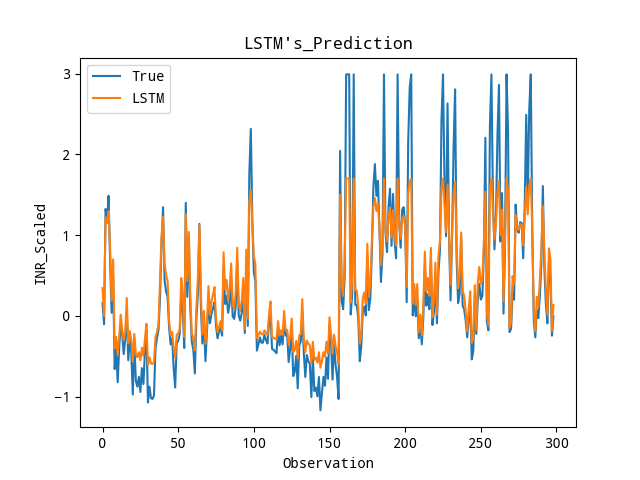

In [243]:
plt.plot(seq.flatten(), label='True')
# plt.plot(y_test, label='True')
plt.plot(res_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [140]:
test_x,test_y = get_batch_boston_test()

In [210]:
prev = test_x[62].reshape(-1,1,1)
start = np.array([])
start = np.append(start,prev)
print(start.shape)





(1,)


In [250]:
start_num = 0
prev = test_x[start_num:start_num+10].reshape(-1,1)
# print(prev)
start = np.array([])
start = np.append(start,prev)
for i in range(30):
#     print(i,"b",prev.shape)
#     prev_list.append(prev)
#     prev_np = np.array(prev_list).reshape(-1,1,1)
#     print(i,"a",prev_np.shape)
#     print(i,"p|",prev)
    y_pred_test_LSTM = model_lstm.predict(start.reshape(-1,1,1))
#     print(y_pred_test_LSTM[-1])
    start = np.append(start,y_pred_test_LSTM[-1])
    print(i,"|",start.shape)
#     prev = y_pred_test_LSTM.reshape(-1,1,1)
    
print('a',start,start.shape)

0 | (11,)
1 | (12,)
2 | (13,)
3 | (14,)
4 | (15,)
5 | (16,)
6 | (17,)
7 | (18,)
8 | (19,)
9 | (20,)
10 | (21,)
11 | (22,)
12 | (23,)
13 | (24,)
14 | (25,)
15 | (26,)
16 | (27,)
17 | (28,)
18 | (29,)
19 | (30,)
20 | (31,)
21 | (32,)
22 | (33,)
23 | (34,)
24 | (35,)
25 | (36,)
26 | (37,)
27 | (38,)
28 | (39,)
29 | (40,)
a [-0.0579893   0.4208956   1.1501067   1.47661914  0.63857056  1.18275795
  0.61680306  0.02908069 -0.24301301 -0.70013041 -0.42129064 -0.27135387
 -0.19672178 -0.14161474 -0.05837372  0.06156963  0.2225859   0.41799411
  0.62557888  0.81312054  0.93604994  1.01020157  1.0528152   1.07665777
  1.08980536  1.09699881  1.10091817  1.10304832  1.10420489  1.10483229
  1.10517263  1.10535717  1.10545719  1.10551143  1.10554087  1.10555673
  1.10556543  1.10557008  1.1055727   1.10557401] (40,)


<IPython.core.display.Javascript object>


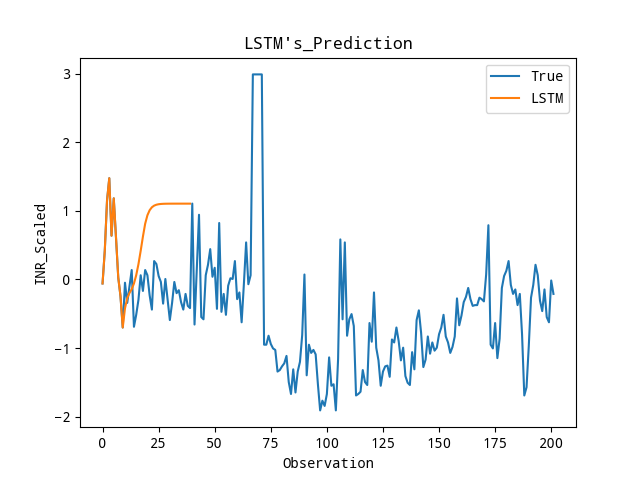

In [251]:
plt.plot(test_x.flatten()[start_num:-1], label='True')
# plt.plot(y_test, label='True')
plt.plot(start.flatten(), label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [43]:
import sys  
from PyQt5.QtWidgets import QApplication, QWidget    #导入相应的包

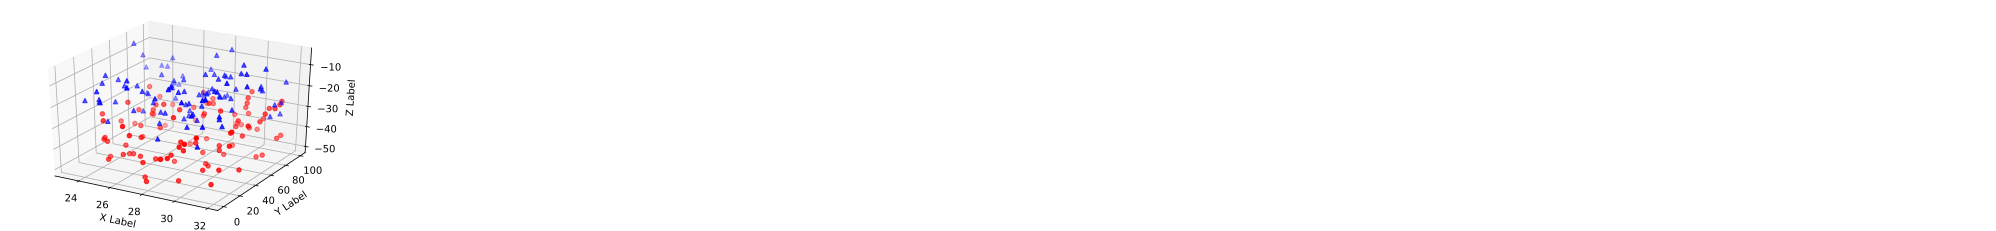

In [31]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'svg'
# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [32]:
from pyecharts import Bar # 柱状图
attr = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
v1 = [2.0, 4.9, 7.0, 23.2, 25.6, 76.7, 135.6, 162.2, 32.6, 20.0, 6.4, 3.3]
v2 = [2.6, 5.9, 9.0, 26.4, 28.7, 70.7, 175.6, 182.2, 48.7, 18.8, 6.0, 2.3]
bar = Bar("Bar chart", "precipitation and evaporation one year")
bar.add("precipitation", attr, v1, mark_line=["average"], mark_point=["max", "min"])
bar.add("evaporation", attr, v2, mark_line=["average"], mark_point=["max", "min"])
# bar.render() # 生成一个html文件

In [37]:
import random

from pyecharts import Scatter3D, Page



def create_charts():
    page = Page()

    data = [
        [random.randint(0, 100),
         random.randint(0, 100),
         random.randint(0, 100)] for _ in range(80)
    ]
    chart = Scatter3D("3D 散点图")
    chart.add("", data, is_visualmap=True)
    page.add(chart)

    return page


In [38]:
create_charts()

In [8]:
%matplotlib
import matplotlib.pyplot as plt

Using matplotlib backend: nbAgg


In [5]:
from matplotlib.font_manager import findfont, FontProperties
findfont(FontProperties(family=FontProperties().get_family()))

'/home/python/anaconda3/envs/specialtopic/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/WenQuanYi Micro Hei Mono.ttf'

In [16]:
from matplotlib.font_manager import _rebuild

In [17]:
_rebuild()